## VaR Sampler

This is a small demo of Value at Risk for a portfolio of three equities (Facebook, Apple, and Amazon).  The intitial portfolio value is $1,000,000.

Calculations are derived from closing stock prices over a five-year time frame, from February 2015 through the end of January 2020.

In [7]:
from __future__ import print_function

### Standard libs
import re
import time
from urllib import (
        request as ureq,
        parse as uparse,
        )
from datetime import datetime as dt


from sys import version_info

if version_info.major < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
    
# Third-party libs
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

Below are some functions to get Yahoo! Finance data.

Note: Your USER_AGENT value might be different if you plan on running this locally.  To find out, you can hit F12 in your browser, go to the Console tab, and type in `navigator.userAgent` to see what User Agent is set for your browser.

In [8]:

class QueryVars:
    
    USER_AGENT = "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:72.0)"
    USER_AGENT += " " + "Gecko/20100101 Firefox/72.0"
    
    def __init__(self, crumb = None, cookie = None, request = ureq):
        self.ureq = ureq
        self.cookie_inst = self.ureq.HTTPCookieProcessor()
        self.url_opener = self.ureq.build_opener(self.cookie_inst)
        self.ureq.install_opener(self.url_opener)
        self.header_ = {
                "User-Agent": self.USER_AGENT,
                }
        self.crumb = crumb
        self.cookie = cookie
    
    @property
    def crumb(self):
        return self.__crumb
    
    @crumb.setter
    def crumb(self, value = None):
        self.__crumb = value
        
    @property
    def cookie(self):
        return self.__cookie
    
    @cookie.setter
    def cookie(self, value = None):
        self.__cookie = value



def get_cookie_and_crumb(ticker, *args):
    """
    Function to set crumb and cookie values for our Yahoo! Finance
    session.
    
    The args will just be an instance of our QueryVars() class from above.
    """
    yf_base = f"https://finance.yahoo.com/quote"
    yf_hist_uri = f"{yf_base}/{ticker}/history?p={ticker}"  
    
    
    args[0].cookie_inst.cookiejar.clear()
    req = args[0].ureq.Request(yf_hist_uri, headers = args[0].header_)
    f = args[0].ureq.urlopen(req)
    data_string = f.read().decode('utf-8')
    
    targets = list()
    tokens = [i for i in data_string.split('\n') if len(i) > 0]
    for i, token in enumerate(tokens):
        if 'CrumbStore' in token:
            targets.append(i)
    
    if len(targets) == 1:
        target = targets[0]
        data = tokens[target]
    else:
        print('Multiple targets found')
    
    crumb_base_pat = r'(?P<crumbs>"CrumbStore":{"crumb":".+?"})'
    p = re.compile(crumb_base_pat)
    crumbs = p.search(data).group('crumbs')
    
    crumb_pat = r'"CrumbStore":{"crumb":"(.+)"}'
    args[0].crumb = re.sub(crumb_pat, r"\1", crumbs)
    
    
    # Extract the cookie from cookiejar
    for c in args[0].cookie_inst.cookiejar:
        if c.domain == '.yahoo.com' and c.name == 'B':
            args[0].cookie = c.value



def validate_date(date_string):
    """Validate and reformat user-entered date strings."""
    
    yr_prefix = str(dt.now().year)[:2]
    
    if re.search(r"-|\/", date_string):
        delim = set(re.findall(r"\D+", date_string)).pop()
        if delim == "/":
            mth, dy, yr = re.split(r"\/", date_string)
        elif delim == "-":
            yr, mth, dy = re.split(r"-", date_string)
            
        if len(yr) > 2:
            yr = str(yr)[-2:]
        mth = f"{int(mth):0>2}"
        dy = f"{int(dy):0>2}"
        return dt.fromisoformat(f"{yr_prefix}{yr}-{mth}-{dy}")
    
    else:
        print("Error determining date type!")
    


def get_stock_data(ticker, start_date, end_date, info_type="quote"):
    """
    Main function to retrieve Yahoo! Finance stock data.
    
    `start_date` and `end_date` can be pretty much any short date format,
    but ISO8601 (YYYY-MM-DD) is preferred.
    
    Available `info_type` values are:
        "quote"
        "dividend"
        "split"
    
    """
    ticker = str(ticker).upper()
    
    qv = QueryVars()
    
    get_cookie_and_crumb(ticker, qv)
    
    start_dt = validate_date(start_date)
    end_dt = validate_date(end_date)
    

    tb = time.mktime((start_dt.year, start_dt.month, start_dt.day, 4, 0, 0, 0, 0, 0))
    te = time.mktime((end_dt.year, end_dt.month, end_dt.day, 18, 0, 0, 0, 0, 0))
    
    type_dict = {
            "q": "history", # Quote
            "d": "div", # Dividend
            "s": "split", # Split
            }  

    
    param_ = dict(
            period1=int(tb),
            period2=int(te),
            interval = '1d'
            )
    
    param_['events'] = type_dict[info_type[0]]
    param_['crumb'] = qv.crumb
    
    params = uparse.urlencode(param_)
    
    url_ = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?{params}"
    # print(url)
    req_ = qv.ureq.Request(url_, headers = qv.header_)    
    
    # Perform the query
    # Cookie will be handled by opener
    resp = qv.ureq.urlopen(req_)
    raw_data = resp.read().decode('utf-8')
    # print(alines)
    resp.close()
    return raw_data


def multiple_tickers(ticker, start_dt, end_dt):
    """Convenience function to handle data retrieval for multiple tickers."""
    res = StringIO(get_stock_data(ticker = ticker,
                       start_date=start_dt,
                       end_date=end_dt))

    data = pd.read_csv(res, sep=",")
    res.close()
    res = None
    data = data.drop(['Open', 'High', 'Low', 'Close','Volume',], axis=1)
    data = data.rename(columns={"Adj Close":f"close_{ticker}"})    
    return data

def pct_return(df_col):
    return (df_col / df_col.shift(1)) - 1

def sqrt_(n):
    return n ** (1/2)

This section sets up a super-simple portfolio.  Weights are derived from the base value, though that would change with a larger portfolio in a production environment.

In [9]:
INIT_INVESTMENT = 1e6 # 1 million
synth_portfolio = {
        'ticker': ['fb','aapl','amzn',],
        'base': [500000.0, 350000.0, 150000.0]
        }

port_df = pd.DataFrame(synth_portfolio)
port_df['weight'] = port_df['base'] / port_df['base'].sum()

In [10]:
# What our portfolio data frame looks like:

print(port_df)

  ticker      base  weight
0     fb  500000.0    0.50
1   aapl  350000.0    0.35
2   amzn  150000.0    0.15


In [11]:
### We'll look at February 2015 through the end of January 2020.
START_DATE = "2015-02-01"
END_DATE = "2020-02-01"

### Collections of tickers and related weightings.
tickers = port_df['ticker'].values
weights = port_df['weight'].values

### Retrieve and concatenate data for multiple tickers inot a single data frame
dfs = [multiple_tickers(t, START_DATE, END_DATE) for t in tickers]
df = pd.concat([df.set_index('Date') for df in dfs], axis=1, join='outer')

In [14]:
### Create dataframe of return values
returns_df = df.pct_change()


### Create covariance matrix
df_cov = returns_df.cov()


### Calculate portfolio mean and standard deviation
mean_ = returns_df.mean()
portfolio_mean_ = mean_ @ weights
portfolio_stdev_ = ((weights.T.dot(df_cov).dot(weights)) ** (1/2))


### Mean and standard deviation of initial investment
investment_mean_ = (1 + portfolio_mean_) * INIT_INVESTMENT
investment_stdev_ = INIT_INVESTMENT * portfolio_stdev_


### Set confidence interval and find inverse of normal cumulative distribution.
CI = 0.95

ci_cutoff = norm.ppf((1 - CI), investment_mean_, investment_stdev_)

### Find Value at Risk for one day
VaR_1_day = INIT_INVESTMENT - ci_cutoff

msg = f"With a {CI * 100:.0f}% confidence interval, "
msg += f"the maximum expected 1-day loss\nfor our ${INIT_INVESTMENT:,.2f} portfolio is ${VaR_1_day:,.2f}."
print(msg)

With a 95% confidence interval, the maximum expected 1-day loss
for our $1,000,000.00 portfolio is $22,429.65.


This cell will look at 20 days worth of data and return a simple plot of the curve.

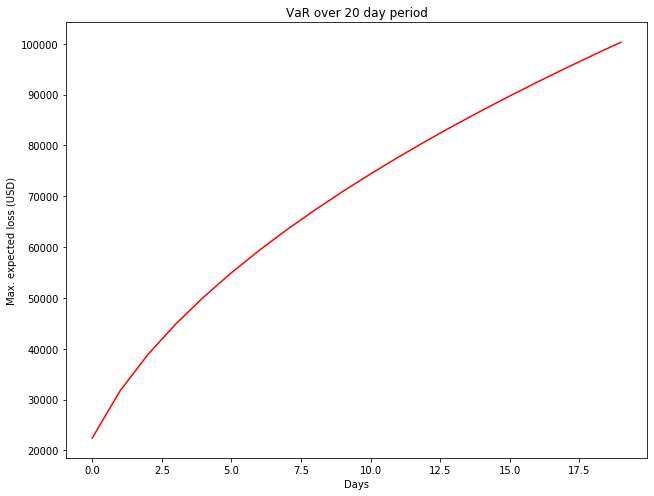

In [15]:
### Multiple day outlook
number_of_days = 20
results = [round(VaR_1_day * sqrt_(d), 2) for d in range(1, number_of_days + 1)]


fig = plt.figure(figsize = (9,7))
plt.title(f"VaR over {number_of_days} day period")
plt.xlabel("Days")
plt.ylabel("Max. expected loss (USD)")
plt.tight_layout()
plt.plot(results, "r")